In [1]:
# PyTorch imports
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchviz import make_dot

# Image files imports
import json
import os
import PIL
from glob import glob

# Utils imports 
import utils
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# SuperNet 
from alternatives import ConvBNRelu, DepthwiseSeparableConv

/opt/rocm/lib/libamd_smi.so: cannot open shared object file: No such file or directory
Unable to find amdsmi library try installing amd-smi-lib from your package manager


In [2]:
# Target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset - ImageNet100

In [3]:
class ImageNet100(Dataset):

    """
    PyTorch torch.utils.Dataset for ImageNet100 classification dataset.
    ------
    IMPORTANT: Uses lazy loading in order to prevent RAM saturation.
    """

    def __init__(self, images, labels, class_to_idx, transform):
        
        # Samples
        self.image_files = images
        self.transform = transform

        # Targets        
        self.class_to_idx = class_to_idx
        self.target = [self.class_to_idx[k] for k in labels]
        self.class_names = list(self.class_to_idx.keys())

    
    def __len__(self):
        return len(self.target)
    
    
    def __getitem__(self, idx):
        # Lazy loading: loading images only when queried
        image = PIL.Image.open(self.image_files[idx])
        
        # Convert all images to RGB
        if not image.mode == 'RGB':
            image = image.convert('RGB')

        # Apply transformations    
        img_tensor = self.transform(image)
        label = self.target[idx]
        
        return img_tensor, label

In [4]:
labels = None
with open('./ImageNet/Labels.json', 'r') as f:
    labels = json.load(f)

labels

{'n01968897': 'chambered nautilus, pearly nautilus, nautilus',
 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio',
 'n01818515': 'macaw',
 'n02011460': 'bittern',
 'n01496331': 'electric ray, crampfish, numbfish, torpedo',
 'n01847000': 'drake',
 'n01687978': 'agama',
 'n01740131': 'night snake, Hypsiglena torquata',
 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'n01491361': 'tiger shark, Galeocerdo cuvieri',
 'n02007558': 'flamingo',
 'n01735189': 'garter snake, grass snake',
 'n01630670': 'common newt, Triturus vulgaris',
 'n01440764': 'tench, Tinca tinca',
 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 'n02002556': 'white stork, Ciconia ciconia',
 'n01667778': 'terrapin',
 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 'n01924916': 'flatworm, platyhelminth',
 'n01751748': 'sea snake',
 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 'n01729

In [5]:
train_images, train_labels = [], []
test_images, test_labels = [], []

# Build class to index for consistency between train and test
idx = 0
class_to_idx = {}

for folder in glob('./ImageNet/*'):

    # Skip file Labels.json
    if not os.path.isdir(folder): 
        continue

    # Type of folder 
    mode = folder.split('/')[-1].split('.')[0]
    
    # Divide images
    for class_folder in glob(f'{folder}/*'):
        # Class label
        key = class_folder.split('/')[-1]
        if key not in class_to_idx.keys():
            class_to_idx[key] = idx
            idx += 1 
        
        # Images
        image_files = glob(f'{class_folder}/*')
        
        for im in image_files:
            if mode == 'train':
                train_images.append(im)
                train_labels.append(key)
            else:
                test_images.append(im)
                test_labels.append(key)


In [6]:
# Pre-processing for training images
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize([232,232]),
    v2.CenterCrop([224,224]),
    v2.TrivialAugmentWide(),
    v2.RandomErasing(p=0.1),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Pre-processing for validation/test images
val_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize([232,232]),
    v2.CenterCrop([224,224]),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Save pickle files of Dataset objects
if not os.path.exists('./ImageNet/train_dataset.pkl'):
    train_dataset = ImageNet100(train_images, train_labels, class_to_idx, train_transforms)
    with open('./ImageNet/train_dataset.pkl', 'wb') as f:
        pickle.dump(train_dataset, f, pickle.HIGHEST_PROTOCOL)
else:
    with open('./ImageNet/train_dataset.pkl', 'rb') as f:
        train_dataset = pickle.load(f)

if not os.path.exists('./ImageNet/test_dataset.pkl'):
    test_dataset = ImageNet100(test_images, test_labels, class_to_idx, val_transforms)
    with open('./ImageNet/test_dataset.pkl', 'wb') as f:
        pickle.dump(test_dataset, f, pickle.HIGHEST_PROTOCOL)
else:
    with open('./ImageNet/test_dataset.pkl', 'rb') as f:
        test_dataset = pickle.load(f)


In [7]:
# Check for labeling consistency between train and test dataset
conflicts = 0
for k in train_dataset.class_to_idx.keys():    
    if train_dataset.class_to_idx[k] != test_dataset.class_to_idx[k]: 
        conflicts += 1
        print(f'Non matching keys - {k}: train {train_dataset.class_to_idx[k]} | test {test_dataset.class_to_idx[k]}')

if conflicts == 0: print('All keys matching!')

All keys matching!


In [8]:
# Test DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=14,
    pin_memory=True
)

# 1 - Standard MobileNetV3

In [9]:
baseline_model = torch.load(f'./main_models/MobileNetV3_seed42.pt', weights_only=False)
baseline_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [6]:
baseline_results = utils.eval_model_comparison(
    model=baseline_model,
    device=device,
    data_loader=test_dataloader
)

baseline_params = utils.count_parameters(baseline_model)
baseline_model_size = utils.model_size(baseline_model)
baseline_flops = utils.count_flops(baseline_model, dataset=test_dataset)

print(f'\nMBNV3 #parameters: {baseline_params} | Size (MB): {baseline_model_size:.3f}')
print(f'MBNV3 #FLOPs: {baseline_flops}')

WARM UP...


  0%|          | 0/6 [00:00<?, ?it/s]


EVALUATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED:
	- Avg Accuracy: 80.73% | Avg Acc@5: 94.99%
	- Inference times (ms) - Max: 54.13 | Min: 5.31 | Avg: 8.14
	- Energy consumption (J) - Max: 3.10700 | Min: 0.21376 | Avg: 0.52302

MBNV3 #parameters: 4330132 | Size (MB): 16.612
MBNV3 #FLOPs: 230163516


# 2- SuperNet L2-CrossEntropy

In [12]:
sn_1 = torch.load(f'./experiments/regularizers/SuperNet_30-01-2025_04:08:57/models/MobileNetV3_exported_seed42.pt', weights_only=False)
sn_1

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [8]:
sn_1_results = utils.eval_model_comparison(
    model=sn_1,
    device=device,
    data_loader=test_dataloader
)

sn_1_size = utils.model_size(sn_1)
sn_1_params = utils.count_parameters(sn_1)
params_ratio = 1 - sn_1_params / baseline_params if sn_1_params <= baseline_params else (sn_1_params - baseline_params) / baseline_params

print(f'\nSuperNet L2-CrossEntropy #parameters: {sn_1_params} | Size (MB): {sn_1_size:.3f}', end=' -> ')
if sn_1_params <= baseline_params:
    print(f'{(params_ratio*100):.2f}% less than baseline')
else:
    print(f'{(params_ratio*100):.2f}% more than baseline')

sn_1_flops = utils.count_flops(sn_1, dataset=test_dataset)
flops_ratio = 1 - sn_1_flops / baseline_flops if sn_1_flops <= baseline_flops else (sn_1_flops - baseline_flops) / baseline_flops

print(f'SuperNet L2-CrossEntropy #FLOPs: {sn_1_flops}', end=' -> ')
if sn_1_flops <= baseline_flops:
    print(f'{(flops_ratio*100):.2f}% less than baseline')
else:
    print(f'{(flops_ratio*100):.2f}% more than baseline')

WARM UP...


  0%|          | 0/6 [00:00<?, ?it/s]


EVALUATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED:
	- Avg Accuracy: 77.02% | Avg Acc@5: 93.33%
	- Inference times (ms) - Max: 43.52 | Min: 5.84 | Avg: 8.51
	- Energy consumption (J) - Max: 3.15000 | Min: 0.26053 | Avg: 0.67783

SuperNet L2-CrossEntropy #parameters: 4257996 | Size (MB): 16.390 -> 1.67% less than baseline
SuperNet L2-CrossEntropy #FLOPs: 346818372 -> 50.68% more than baseline


# 3 - Parameter-based experiments

## 3.1 - SuperNet L2-CrossEntropy + Stable Weighted Parameters 

In [7]:
sn_2 = torch.load(f'./experiments/regularizers/SuperNet_31-01-2025_05:57:38/models/MobileNetV3_exported_seed42.pt', weights_only=False)
sn_2

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:
sn_2_results = utils.eval_model_comparison(
    model=sn_2,
    device=device,
    data_loader=test_dataloader
)

sn_2_size = utils.model_size(sn_2)
sn_2_params = utils.count_parameters(sn_2)
params_ratio = 1 - sn_2_params / baseline_params if sn_2_params <= baseline_params else (sn_2_params - baseline_params) / baseline_params

print(f'\nSuperNet L2-CrossEntropy+SWP #parameters: {sn_2_params} | Size (MB): {sn_2_size:.3f}', end=' -> ')
if sn_2_params <= baseline_params:
    print(f'{(params_ratio*100):.2f}% less than baseline')
else:
    print(f'{(params_ratio*100):.2f}% more than baseline')

WARM UP...


  0%|          | 0/6 [00:00<?, ?it/s]


EVALUATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED:
	- Avg Accuracy: 77.50% | Avg Acc@5: 92.91%
	- Inference times (ms) - Max: 33.98 | Min: 6.44 | Avg: 8.21
	- Energy consumption (J) - Max: 1.90325 | Min: 0.25538 | Avg: 0.60687

SuperNet L2-CrossEntropy+SWP #parameters: 4013124 | Size (MB): 15.444 -> 7.32% less than baseline


## 3.2 - SuperNet L2-CrossEntropy + Target Weighted Parameters 

In [11]:
sn_3 = torch.load(f'./experiments/regularizers/SuperNet_01-02-2025_06:30:27/models/MobileNetV3_exported_seed42.pt', weights_only=False)
sn_3

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [12]:
sn_3_results = utils.eval_model_comparison(
    model=sn_3,
    device=device,
    data_loader=test_dataloader
)

sn_3_size = utils.model_size(sn_3)
sn_3_params = utils.count_parameters(sn_3)
params_ratio = 1 - sn_3_params / baseline_params if sn_3_params <= baseline_params else (sn_3_params - baseline_params) / baseline_params

print(f'\nSuperNet L2-CrossEntropy+SWP #parameters: {sn_3_params} | Size (MB): {sn_3_size:.3f}', end=' -> ')
if sn_3_params <= baseline_params:
    print(f'{(params_ratio*100):.2f}% less than baseline')
else:
    print(f'{(params_ratio*100):.2f}% more than baseline')

WARM UP...


  0%|          | 0/6 [00:00<?, ?it/s]


EVALUATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED:
	- Avg Accuracy: 76.68% | Avg Acc@5: 93.07%
	- Inference times (ms) - Max: 24.17 | Min: 6.29 | Avg: 8.20
	- Energy consumption (J) - Max: 1.42200 | Min: 0.31310 | Avg: 0.58402

SuperNet L2-CrossEntropy+SWP #parameters: 3482412 | Size (MB): 13.401 -> 19.58% less than baseline


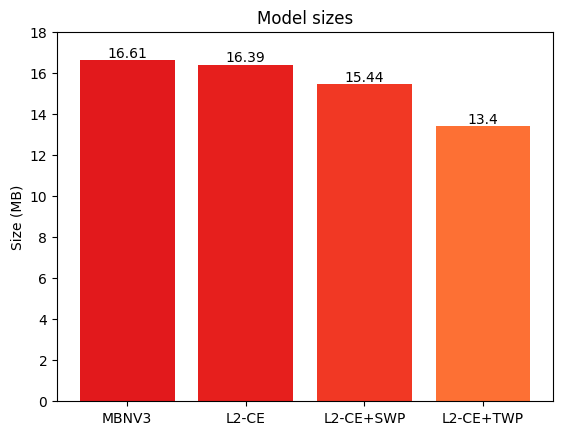

In [13]:
model_sizes = [round(baseline_model_size, 2), round(sn_1_size, 2), round(sn_2_size, 2), round(sn_3_size, 2)]
model_names = ['MBNV3', 'L2-CE', 'L2-CE+SWP', 'L2-CE+TWP']

cmap = plt.get_cmap('YlOrRd')
model_colors = [cmap(size/max(model_sizes)-0.25) for size in model_sizes]

plt.title('Model sizes')
rects = plt.bar(model_names, model_sizes, color=model_colors)
plt.bar_label(rects)
plt.ylim(0,18.0)
plt.ylabel('Size (MB)');

# 4 - FLOPs-based experiments

## 4.1 SuperNet L2-CrossEntropy + Stable wieghted FLOPs

In [9]:
sn_4 = torch.load(f'./experiments/regularizers/SuperNet_02-02-2025_04:15:10/models/MobileNetV3_exported_seed42.pt', weights_only=False)
sn_4

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:
sn_4_results = utils.eval_model_comparison(
    model=sn_4,
    device=device,
    data_loader=test_dataloader
)

sn_4_flops = utils.count_flops(sn_4, dataset=test_dataset)
flops_ratio = 1 - sn_4_flops / baseline_flops if sn_4_flops <= baseline_flops else (sn_4_flops - baseline_flops) / baseline_flops

print(f'\nSuperNet L2-CrossEntropy+SWF #FLOPs: {sn_4_flops}', end=' -> ')
if sn_4_flops <= baseline_flops:
    print(f'{(flops_ratio*100):.2f}% less than baseline')
else:
    print(f'{(flops_ratio*100):.2f}% more than baseline')

WARM UP...


  0%|          | 0/6 [00:00<?, ?it/s]


EVALUATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED:
	- Avg Accuracy: 78.17% | Avg Acc@5: 93.75%
	- Inference times (ms) - Max: 26.89 | Min: 6.73 | Avg: 8.29
	- Energy consumption (J) - Max: 2.72800 | Min: 0.29814 | Avg: 0.63926

SuperNet L2-CrossEntropy+SWF #FLOPs: 326929860 -> 42.04% more than baseline


## 4.2 SuperNet L2-CrossEntropy + Target wieghted FLOPs

In [11]:
sn_5 = torch.load(f'./experiments/regularizers/SuperNet_03-02-2025_04:45:18/models/MobileNetV3_exported_seed42.pt', weights_only=False)
sn_5

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [12]:
sn_5_results = utils.eval_model_comparison(
    model=sn_5,
    device=device,
    data_loader=test_dataloader
)

sn_5_flops = utils.count_flops(sn_5, dataset=test_dataset)
flops_ratio = 1 - sn_5_flops / baseline_flops if sn_5_flops <= baseline_flops else (sn_5_flops - baseline_flops) / baseline_flops

print(f'\nSuperNet L2-CrossEntropy+TWF #FLOPs: {sn_5_flops}', end=' -> ')
if sn_5_flops <= baseline_flops:
    print(f'{(flops_ratio*100):.2f}% less than baseline')
else:
    print(f'{(flops_ratio*100):.2f}% more than baseline')

WARM UP...


  0%|          | 0/6 [00:00<?, ?it/s]


EVALUATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED:
	- Avg Accuracy: 78.13% | Avg Acc@5: 93.63%
	- Inference times (ms) - Max: 18.19 | Min: 3.46 | Avg: 8.02
	- Energy consumption (J) - Max: 1.44100 | Min: 0.24095 | Avg: 0.55524

SuperNet L2-CrossEntropy+TWF #FLOPs: 262456836 -> 14.03% more than baseline


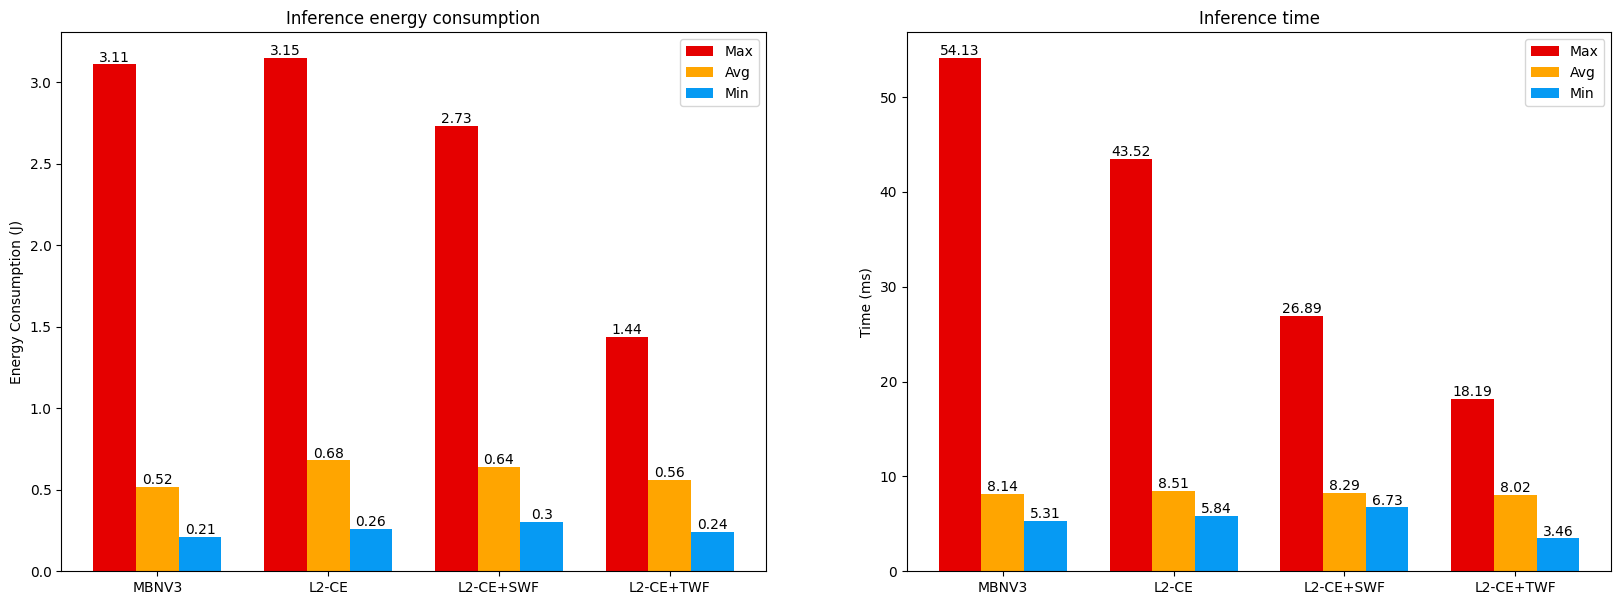

In [56]:
model_names = ['MBNV3', 'L2-CE', 'L2-CE+SWF', 'L2-CE+TWF']
x = np.arange(len(model_names))

# Energy consumption info
model_max_p = [round(baseline_results['max_p'], 2), round(sn_1_results['max_p'], 2), round(sn_4_results['max_p'], 2), round(sn_5_results['max_p'], 2)]
model_avg_p = [round(baseline_results['avg_p'], 2), round(sn_1_results['avg_p'], 2), round(sn_4_results['avg_p'], 2), round(sn_5_results['avg_p'], 2)]
model_min_p = [round(baseline_results['min_p'], 2), round(sn_1_results['min_p'], 2), round(sn_4_results['min_p'], 2), round(sn_5_results['min_p'], 2)]

# Inference time info
model_max_t = [round(baseline_results['max_t']*1000, 2), round(sn_1_results['max_t']*1000, 2), round(sn_4_results['max_t']*1000, 2), round(sn_5_results['max_t']*1000, 2)]
model_avg_t = [round(baseline_results['avg_t']*1000, 2), round(sn_1_results['avg_t']*1000, 2), round(sn_4_results['avg_t']*1000, 2), round(sn_5_results['avg_t']*1000, 2)]
model_min_t = [round(baseline_results['min_t']*1000, 2), round(sn_1_results['min_t']*1000, 2), round(sn_4_results['min_t']*1000, 2), round(sn_5_results['min_t']*1000, 2)]

fig = plt.figure(figsize=[20,7])

ax = plt.subplot(1,2,1)
ax.set_title('Inference energy consumption')
rects_max_p = ax.bar(x - 0.25, model_max_p, 0.25, label='Max', color='xkcd:red'); ax.bar_label(rects_max_p)
rects_avg_p = ax.bar(x, model_avg_p, 0.25, label='Avg', color='orange'); ax.bar_label(rects_avg_p)
rects_min_p = ax.bar(x + 0.25, model_min_p, 0.25, label='Min', color='xkcd:azure'); ax.bar_label(rects_min_p)
ax.set_ylabel('Energy Consumption (J)')
ax.set_xticks(x, model_names)
ax.legend(loc='upper right')

ax = plt.subplot(1,2,2)
ax.set_title('Inference time')
rects_max_t = ax.bar(x - 0.25, model_max_t, 0.25, label='Max', color='xkcd:red'); ax.bar_label(rects_max_t)
rects_avg_t = ax.bar(x, model_avg_t, 0.25, label='Avg', color='orange'); ax.bar_label(rects_avg_t)
rects_min_t = ax.bar(x + 0.25, model_min_t, 0.25, label='Min', color='xkcd:azure'); ax.bar_label(rects_min_t)
ax.set_ylabel('Time (ms)')
ax.set_xticks(x, model_names)
ax.legend(loc='upper right');